# Imports

In [1]:
import sys
import os
import random
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from exploration import read_and_split, find_tweet_with_pattern, length_distribution
from processing import clean_text, tokenize, extract_correct_words, remove_stop_words, extract_lemma
from processing_helpers import TyposReplacer, TweetProcessor

## Loading and spliting the dataset

We load the dataset and split it into training and test sets, with 80% of the data going to the training set. Then we split the training set into training and validation sets with the same ratio. The implementation of the function read_and_split can be found in src/processing.py.

In [2]:
X_train, y_train, X_valid, y_valid, _, _ = read_and_split('../data/raw/tweets.csv')

# Exploration

## Target classes distribution

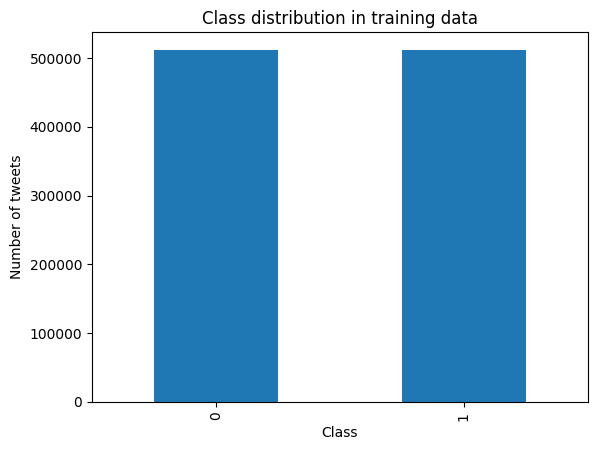

In [4]:
fig, ax = plt.subplots()
y_train.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Class distribution in training data')
ax.set_xlabel('Class')
ax.set_ylabel('Number of tweets')
plt.show()

Both classes are equally represented in the dataset.

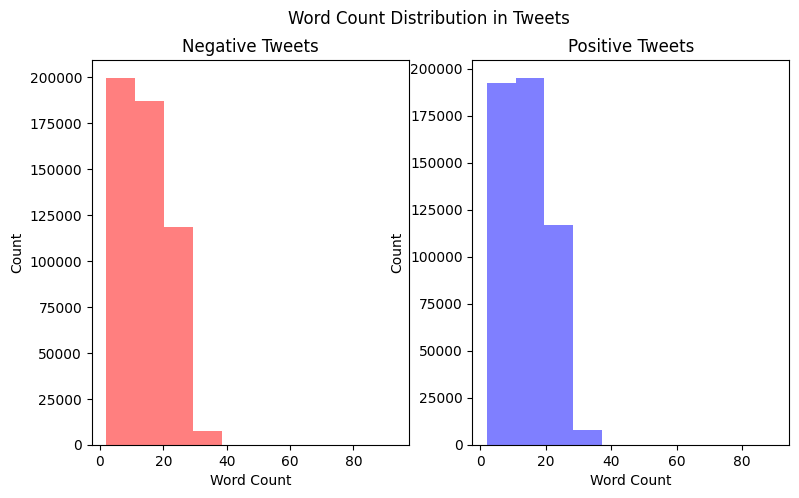

In [3]:
length_distribution(X_train, y_train)

## Exploring tweets

By sampling examples from the dataset, one can quickly find potential issues, anomalies, and regularities. We use a simple function for finding patterns, which we show below. Its implementation can be found in src/exploration.py.

In many tweets, we can find emojis, which are really important in our use case as they carry information about emotion. Later, we will replace all positive and negative emojis with tags EMO_POS and EMO_NEG, respectively.

In [16]:
tweet_with_emoji = find_tweet_with_pattern(X_train, ":-D")
print(tweet_with_emoji)

@Number1Huggles Yep - the right job for me is out there and on its way to me :-D Positive things happen to positive people  x Hows u? x


Hashtags and mentions also often appear in our dataset, which is quite obvious since we use Twitter data. During the processing stage, we replace them with the tags HASH and USR_MEN.

In [22]:
tweet_with_ment_and_hash = find_tweet_with_pattern(X_train, "@[\w]+.*#[\w]+")
print(tweet_with_ment_and_hash)

Thank you my friend  @jodymal #FollowFriday


We also replace every occurrence of a URL with the tag URL.

In [24]:
tweet_with_url = find_tweet_with_pattern(X_train, "https")
print(tweet_with_url)

Free Chocolate Fridays thanks to #mars. Secure your free chocolate here https://secure.realchocolate.com/ before there gone 


# Processing

All functions used in processing stage can be found in src/processing.py.

## Text cleaning
This will include transforming text to lowercase, replacing emojis, mentions, hashtags and URLs, replacing multiple spaces with a single space and fixing common typos.

In [13]:
example_tweet = X_train.iloc[random.randint(0, len(X_train) - 1)]['text']
after_cleaning = clean_text(example_tweet)
typos_replacer = TyposReplacer()
after_processing = typos_replacer.replace(after_cleaning)

print(f'Before: {example_tweet} \nAfter: {after_processing}')

Before: @sarahmarina Okay...I loooove the Celtics even before I loved NKOTB... but the Lakers outfits on them are too funny!!!!  Awesome! 
After: USR_MEN okay...i loooove the celtics even before i loved nkotb... but the lakers outfits on them are too funny!!!! awesome!


## Tokenization

Tokenization is the process of splitting text into individual words or tokens. After tokenization we extract tokens that consist only of only alphabetic characters and remove duplicate letters (more than 2 consecutive).

In [ ]:
#nltk.download('punkt')

In [14]:
after_tokenization = tokenize(after_processing)
words_extracted = extract_correct_words(after_tokenization)
print(f'Before: {after_processing} \nAfter: {words_extracted}')

Before: USR_MEN okay...i loooove the celtics even before i loved nkotb... but the lakers outfits on them are too funny!!!! awesome! 
After: ['USR_MEN', 'okay', 'i', 'loove', 'the', 'celtics', 'even', 'before', 'i', 'loved', 'nkotb', 'but', 'the', 'lakers', 'outfits', 'on', 'them', 'are', 'too', 'funny', 'awesome']


## Removing stop words

Stop words are considered to have little semantic value because they are so frequent and do not contribute significantly to the meaning or the structure of the text. Examples of stop words in English include "the" "is" "in" "and" "a" "an" and "of."

Removing stop words can help reduce the dimensionality of the data and improve the performance the model by focusing on the more meaningful words that are more likely to carry important information.

In [ ]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [15]:
after_filtration = remove_stop_words(words_extracted)
print(f'Before: {words_extracted} \nAfter: {after_filtration}')

Before: ['USR_MEN', 'okay', 'i', 'loove', 'the', 'celtics', 'even', 'before', 'i', 'loved', 'nkotb', 'but', 'the', 'lakers', 'outfits', 'on', 'them', 'are', 'too', 'funny', 'awesome'] 
After: ['USR_MEN', 'okay', 'loove', 'celtics', 'even', 'loved', 'nkotb', 'lakers', 'outfits', 'funny', 'awesome']


## Stemming / Lemmatizing

Stemming is a text preprocessing technique used in natural language processing (NLP) to reduce words to their base or root form. It involves removing suffixes from words to obtain the stem, which may not always be a valid word itself. The purpose of stemming is to normalize words and reduce them to a common form, so that variations of the same word can be treated as the same word during analysis.

Lemmatization is a similar process with its advantages, but it comes at the price of being more resource-consuming.

In [16]:
lemmatizer = WordNetLemmatizer()
after_extraction = extract_lemma(after_filtration, lemmatizer)
print(f'Before: {after_filtration} \nAfter: {after_extraction}')

Before: ['USR_MEN', 'okay', 'loove', 'celtics', 'even', 'loved', 'nkotb', 'lakers', 'outfits', 'funny', 'awesome'] 
After: ['USR_MEN', 'okay', 'loove', 'celtic', 'even', 'loved', 'nkotb', 'lakers', 'outfit', 'funny', 'awesome']


## Processing datasets

In [34]:
typos_replacer = TyposReplacer()
lemmatizer = WordNetLemmatizer()

tweet_processor = TweetProcessor(typos_replacer, lemmatizer)

In [36]:
X_train = X_train.apply(tweet_processor.process_tweet)
X_valid = X_valid.apply(tweet_processor.process_tweet)

In [14]:
X_train

1370443                     night dance know dancing machine
1301249                     back gym excellent workout happy
94491                USR_MEN little fella mind not nice laff
407255           chillin getting drunk im fighting wit juvie
429625                                   footy fun ahh study
                                 ...                        
719998     actually got rockin gift USR_MEN father day ho...
420883     USR_MEN sorry message look like default one th...
1336659              thankfully getting cooler teatime yeeha
1430981           ah totally miss roomy USR_MEN USR_MEN well
298949                               aww surpise find cookie
Name: text, Length: 1023999, dtype: object

In [37]:
X_train.to_pickle('../data/processed/processed_train.pkl')
X_valid.to_pickle('../data/processed/processed_valid.pkl')

# Converting to feature vectors

## Bag of Words

Bag of Words is a text representation technique used in natural language processing. It involves creating a vocabulary of unique words from a corpus of text documents and representing each document as a vector of word frequencies. In the Bag of Words model, the order and structure of the words are disregarded, and only the occurrence of words is considered.

In [38]:
count_vectorizer = CountVectorizer(
    lowercase=False, #already lowercase
    ngram_range=(1,2), #both uni- and bi- grams
    max_df=0.93
)

train_data_fitted = count_vectorizer.fit(X_train)

In [39]:
train_data_features = count_vectorizer.transform(X_train)
valid_data_features = count_vectorizer.transform(X_valid)

In [40]:
pickle.dump(train_data_features, open('../data/processed/features_train.pkl', 'wb'))
pickle.dump(valid_data_features, open('../data/processed/features_valid.pkl', 'wb'))

## TF-IDF

TF-IDF is a statistical measure used in Natural Language Processing to evaluate the importance of a word in a document relative to a collection of documents.

1. **Term Frequency (TF):**
   - Measures how frequently a term appears in a document.
   - Formula: 
     $$
     \text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
     $$
   
2. **Inverse Document Frequency (IDF):**
   - Measures how important a term is within the entire corpus.
   - Formula: 
     $$
     \text{IDF}(t, D) = \log \left( \frac{\text{Total number of documents in the corpus}}{\text{Number of documents containing the term } t} \right)
     $$
   
3. **TF-IDF Score:**
   - Combines TF and IDF to compute a weight for each term in a document.
   - Formula: 
     $$
     \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
     $$

We can directly transform our previous matrix into tfidf representation using a dedicated transformer.

In [32]:
tfidf_transformer = TfidfTransformer()

train_data_features_tfidf = tfidf_transformer.fit_transform(train_data_features)
valid_data_features_tfidf = tfidf_transformer.transform(valid_data_features)

In [42]:
pickle.dump(train_data_features_tfidf, open('../data/processed/features_train_tfidf.pkl', 'wb'))
pickle.dump(valid_data_features_tfidf, open('../data/processed/features_valid_tfidf.pkl', 'wb'))